In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
dfTrain = pd.read_csv('../data/TRAIN_TEST_corrected2/train_corrected2.csv').sample(frac=0.05)
train = dfTrain.drop(columns=['price_usd', 'id'], axis=1)
target = dfTrain.price_usd

In [3]:
# NORMALIZACION DEL DATASET:

##########################################################################
#MinMaxScaler                                                            #
#scaler = MinMaxScaler(feature_range=(0, 1))                             #
#train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)#
##########################################################################

##########################################################################
#Normalizer                                                              #
scaler = Normalizer().fit(train)                                         #
train = pd.DataFrame(scaler.transform(train), columns=train.columns)     #
##########################################################################

In [4]:
train.head(3)

,year_created,month_created,day_created,distance_to_obelisco_mtrs,lat,lon,surface_total_in_m2,rooms,PH,apartment,house,store
0,0.117283,0.000116,0.001223,0.993086,-0.002012,-0.003410,0.002621,0.000175,0.000000,0.000058,0.00000,0.0
1,0.129932,0.000258,0.001096,0.991492,-0.002225,-0.003772,0.006448,0.000129,0.000064,0.000000,0.00000,0.0
2,0.101046,0.000251,0.001205,0.994865,-0.001736,-0.002941,0.004518,0.000100,0.000000,0.000000,0.00005,0.0


In [5]:
# PARAMETROS PARA KNN
param_grid = [
                {'n_neighbors': [5, 10, 15, 20, 25, 30, 40, 50, 75],
                 'weights': ['uniform', 'distance'],
                 'metric': ['euclidean', 'manhattan', 'chebyshev']}]

# MEDIDA DE SCORE PARA CROSS-VALIDATION
scoring = {'MSE': 'neg_mean_squared_error'}

knn = KNeighborsRegressor(n_jobs=-1)
gs = GridSearchCV(knn, scoring=scoring, param_grid=param_grid, cv=10, refit='MSE', return_train_score=False)

In [6]:
# COMIENZO EL GRID SEARCH
gs.fit(train, target);

In [7]:
results = gs.cv_results_
dfResults = pd.DataFrame(results).loc[:, ('rank_test_MSE', 'mean_test_MSE', 
                                          'param_metric', 'param_n_neighbors', 'param_weights')].infer_objects()

In [8]:
dfResults.sort_values(by='rank_test_MSE').head(10)

,rank_test_MSE,mean_test_MSE,param_metric,param_n_neighbors,param_weights
35,1,-5.685378e+10,manhattan,75,distance
33,2,-5.699423e+10,manhattan,50,distance
31,3,-5.718541e+10,manhattan,40,distance
17,4,-5.720116e+10,euclidean,75,distance
53,5,-5.743317e+10,chebyshev,75,distance
15,6,-5.747957e+10,euclidean,50,distance
29,7,-5.750945e+10,manhattan,30,distance
13,8,-5.773922e+10,euclidean,40,distance
51,9,-5.780708e+10,chebyshev,50,distance
27,10,-5.783108e+10,manhattan,25,distance


In [9]:
combinatorias = set()

for metric in param_grid[0]['metric'] :
    for weight in param_grid[0]['weights'] :
        tupla = (metric, weight)
        
        if tupla not in combinatorias and tupla[::-1] not in combinatorias :
            combinatorias.add(tupla)
            
dfs = []

for opcion in combinatorias :
    dfs.append(dfResults.loc[dfResults.param_metric.str.contains(opcion[0]) & dfResults.param_weights.str.contains(opcion[1])])

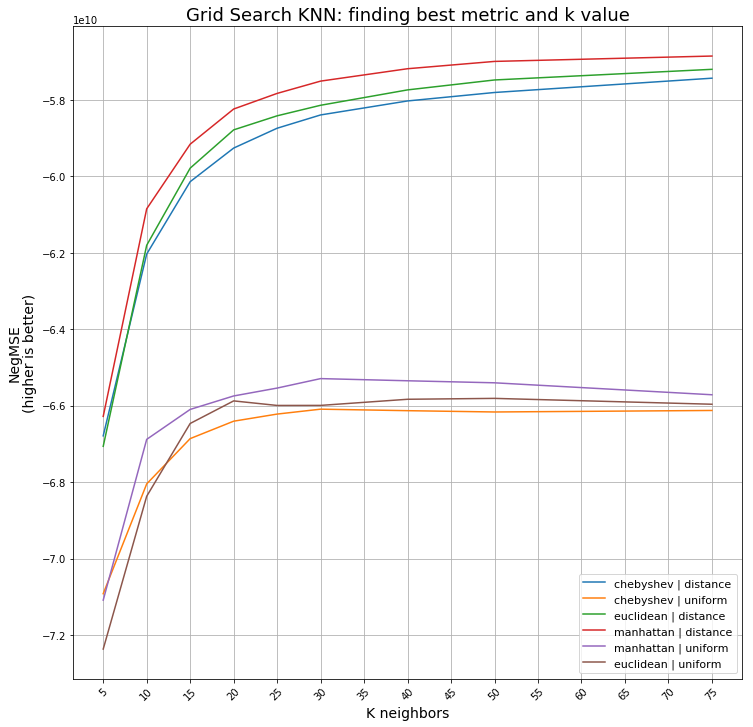

In [38]:
# Ploteo los resultados

ax = None
for df in dfs :
    df = df.reset_index()
    new_name = df.param_metric[0] + ' | ' + df.param_weights[0]
    df = df.rename(columns={'mean_test_MSE':new_name })
    ax = df.plot(ax=ax, x='param_n_neighbors', y=new_name, 
                 figsize=(12, 12), rot=45)

ax.grid()
ax.set_title("Grid Search KNN: finding best metric and k value", fontsize=18)
ax.set_xlabel('K neighbors', fontsize=14)
ax.set_ylabel('NegMSE\n(higher is better)', fontsize=14)
ax.legend(fontsize=11)

neighbors = param_grid[0]['n_neighbors']
step = 5
ax.set_xticks(np.arange(min(neighbors), max(neighbors) + step, step));
ax.tick_params(axis = 'x', labelsize = 9)

In [11]:
print "\nMejores parametros:", gs.best_params_
print "Tuvieron un error de:", repr(-gs.best_score_), "midiendo como MSE"


Mejores parametros: {'n_neighbors': 75, 'metric': 'manhattan', 'weights': 'distance'}
Tuvieron un error de: 56853781735.73214 midiendo como MSE
